In [1]:
#Import libraries
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

# Load the English model
nlp = spacy.load("en_core_web_sm")

Mounted at /content/drive


In [3]:
#Load training and testing dataset and perform initial data exploration on training data
train_data = pd.read_excel('/content/drive/MyDrive/AAI520/MODULE4/Legal_Sentences_For_Training_With_BERT_With_Label.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/AAI520/MODULE4/Testing_Set_Legal_Sentences.xlsx')
test_data.rename(columns = {'sentence':'Phrase', 'label':'Label'}, inplace = True)
print(train_data.sample(6))
print('\n')
print(train_data.info())
print('\n')
print('Sentiment Distribution: \n', train_data['Label'].value_counts())

      ID                                             Phrase  Sentiment  Label
300  301              It promotes the laws deterrent effect         -1      0
210  211  the trial court improperly denied his for-caus...         -1      0
516  517        they are in harmony with our holding today.          1      2
146  147  recklessness with respect to the harmful conse...         -1      0
127  128  the cited report describes many of these measu...         -1      0
101  102           the Court today reviews a case as tragic          0      1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         576 non-null    int64 
 1   Phrase     576 non-null    object
 2   Sentiment  576 non-null    int64 
 3   Label      576 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 18.1+ KB
None


Sentiment Distribution: 
 0    282
2    172
1    122
Nam

In [4]:
#Preprocess the data
#tokenization, lowercase, and remove stop words and punctuation
def clean (data):
  data['Phrase'] = data['Phrase'].astype(str)
  df = []
  for i in data['Phrase']:
    doc = nlp(i)
    sw = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    text = ' '.join([str(elem) for elem in sw])
    text_low = text.lower()
    df.append(text_low)
  data['Phrase'] = df
  return (data)

clean(train_data)
clean(test_data)
print(train_data.sample(5))

      ID                                             Phrase  Sentiment  Label
527  528                                promote respect law          1      2
435  436       participants course justifiably reimprisoned          1      2
236  237  having completed arduous detour question agree...         -1      0
99   100  jurys deadlock lesser included offense justifi...          1      2
350  351                             s broad ban possession          0      1


In [5]:
#Semantic analysis
#Keyword extraction using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,1))
x_train = vectorizer.fit_transform(train_data['Phrase'])

#create dictionary with tfidf values for every phrase
dict_of_tokens={i[1]:i[0] for i in vectorizer.vocabulary_.items()}
tfidf_vectors = []
for row in x_train:
  tfidf_vectors.append({dict_of_tokens[column]:value for (column,value) in zip(row.indices,row.data)})

#Sort keywords in descending order
doc_sorted_tfidfs =[]
for dn in tfidf_vectors:
  newD = sorted(dn.items(), key=lambda x: x[1], reverse=True)
  newD = dict(newD)
  doc_sorted_tfidfs.append(newD)

print('Keywords from first 5 phrases:')
for i in range(0,6):
  print( doc_sorted_tfidfs[i])

Keywords from first 5 phrases:
{'surplusage': 0.7447746909102526, 'getting': 0.6673160119310322}
{'existing': 0.449643664850579, 'bivens': 0.449643664850579, 'narrow': 0.449643664850579, 'scope': 0.4222883522927421, 'suggested': 0.40287944915450863, 'court': 0.2298312880050527}
{'grooming': 0.3276999529307401, 'corrections': 0.3276999529307401, 'department': 0.3276999529307401, 'arkansas': 0.3276999529307401, 'beard': 0.3276999529307401, 'shaving': 0.3276999529307401, 'objection': 0.3276999529307401, 'clashes': 0.30776342243255606, 'policy': 0.2936182289337218, 'petitioners': 0.2595365049367035}
{'clashes': 0.7472716016417047, 'result': 0.6645187381705963}
{'seizures': 0.3593044220789747, 'determined': 0.3593044220789747, 'duration': 0.3593044220789747, 'context': 0.3374451465287464, 'traffic': 0.3374451465287464, 'inquiries': 0.3374451465287464, 'tolerable': 0.32193574370509664, 'stop': 0.3000764681548684, 'police': 0.2782171926046401}
{'inconsistency': 0.3742502801533488, 'resolve': 

In [6]:
#Sentiment Analysis
#Label 0 = negative sentiment, 1 = neutral, 2 = positive
train_data['Label'] = train_data['Label'].replace(0,'negative')
train_data['Label'] = train_data['Label'].replace(1,'neutral')
train_data['Label'] = train_data['Label'].replace(2,'positive')
test_data['Label'] = test_data['Label'].replace(0,'negative')
test_data['Label'] = test_data['Label'].replace(1,'neutral')
test_data['Label'] = test_data['Label'].replace(2,'positive')

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['Label'])
y_test = label_encoder.transform(test_data['Label'])
x_test = vectorizer.transform(test_data['Phrase'])

In [7]:
#SVM Classifier
svm = SVC(kernel='rbf', C=1, probability=True, random_state=42)
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

In [8]:
#Naive Bayes Classifier
mnb = MultinomialNB(alpha=1)
mnb.fit(x_train, y_train)
y_pred_mnb = mnb.predict(x_test)

In [9]:
#Gradient Boosting Classifier
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
gbc.fit(x_train, y_train)
y_pred_gbc = gbc.predict(x_test)

In [10]:
#Evaluation function
def evaluate(y_test, y_pred, auc,cmc):
  accuracy_tfidf = accuracy_score(y_test, y_pred)
  precision_tfidf = precision_score(y_test, y_pred, average='weighted')
  recall_tfidf = recall_score(y_test, y_pred, average='weighted')
  f1_score_tfidf = f1_score(y_test, y_pred, average='weighted')
  auc_roc_tfidf = roc_auc_score(y_test, auc, multi_class='ovo', average='macro')
  print('Performance Evaluation:')
  print("Accuracy:", accuracy_tfidf)
  print("Precision:", precision_tfidf)
  print("Recall:", recall_tfidf)
  print("F1 Score:", f1_score_tfidf)
  print("AUC-ROC Score:", auc_roc_tfidf)

  confusion_matrix_tfidf = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_tfidf, display_labels=cmc)
  disp.plot()
  plt.show()

Performance Evaluation:
Accuracy: 0.456
Precision: 0.7480058701235172
Recall: 0.456
F1 Score: 0.32014899201198443
AUC-ROC Score: 0.6264213191184324


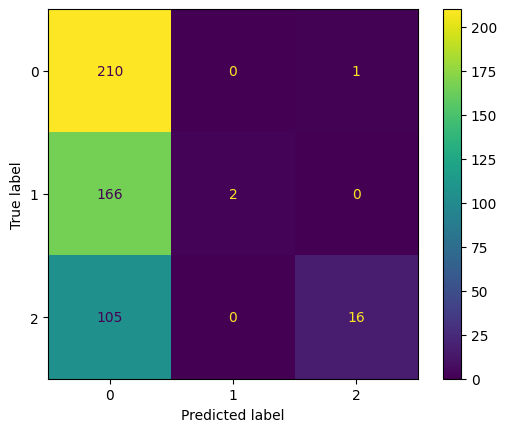

In [11]:
#Evaluate SVM model
evaluate(y_test, y_pred_svm, svm.predict_proba(x_test), svm.classes_)

Performance Evaluation:
Accuracy: 0.454
Precision: 0.4867088036117382
Recall: 0.454
F1 Score: 0.3393948372009354
AUC-ROC Score: 0.6149346996772675


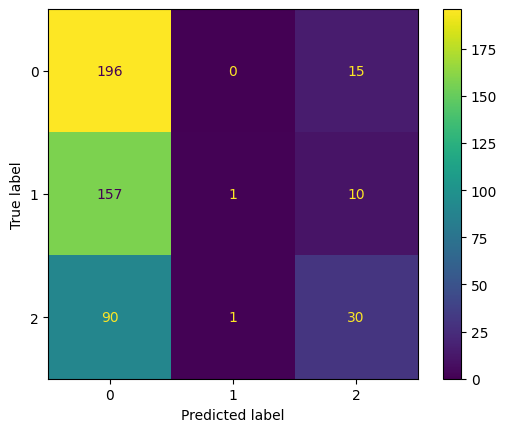

In [12]:
#Evaluate Naive Bayes model
evaluate(y_test, y_pred_mnb, mnb.predict_proba(x_test), mnb.classes_)

Performance Evaluation:
Accuracy: 0.464
Precision: 0.46174866232117784
Recall: 0.464
F1 Score: 0.41547537640114207
AUC-ROC Score: 0.5906213532506078


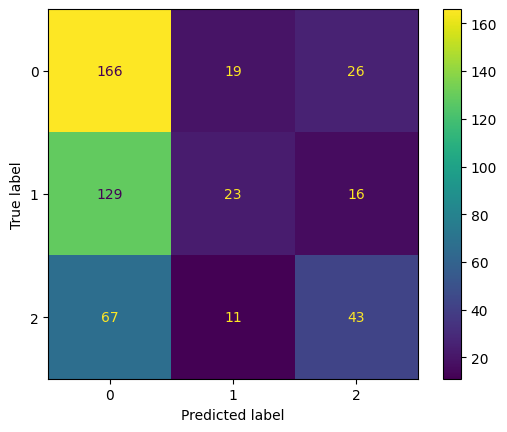

In [13]:
#Evaluate Gradient Boosting model
evaluate(y_test, y_pred_gbc, gbc.predict_proba(x_test), gbc.classes_)